## Emotion recognition from speech using CNN transfer learning



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd


## Organizing audio data into folders according to class

* Each .csv file contain the .wav filenames associated with each emotion
* These .wav files are stored in 5 different folders, Session1, Session2 etc
* The next cell searches all the files associated with each emotion in those folders and stores them in specific folders organized by emotion
* The resulting audio files are stored in subflders inside the folder "audio"
* In tnis notebook we only consider the emotions "sadness", "anger", "happiness" and "neutral". Other classes could be include by modifying the code below

In [7]:
from prep_data import create_data_dir

    
pathData = './data'
pathDataOrig = './data/orig'
create_data_dir(pathData,pathDataOrig)

Emotion: anger
Emotion: happiness
Emotion: neutral
Emotion: sadness


## Converting audio files into images based on spectrogram

The cells below create image files based on the signals in 'pathAudio' folder and store those images in 'pathImage' folder, organizing the files in subfolders according to emotion class


In [ ]:
from melspec_extrac import * 

emotions = ['anger','happiness', 'neutral', 'sadness']

for emotion in emotions:
    print('Emotion: ' + emotion)
    pathAudioEmotion = Path(pathAudio+emotion)
    pathImageEmotion = Path(pathImage+emotion)
    print(pathAudioEmotion)
    print(pathImageEmotion)
    audio_to_spectrogram(pathAudioEmotion, pathImageEmotion)

## Training ResNet model using transfer learning 

### Split train and validation data, with 20% for the latter

In [18]:
np.random.seed(42)
data = ImageDataBunch.from_folder(pathImage, train='.', valid_pct=0.2,
        ds_tfms=None, size=[400,600], num_workers=4).normalize(imagenet_stats)

In [5]:
data.classes

['sadness', 'anger', 'neutral', 'happiness']

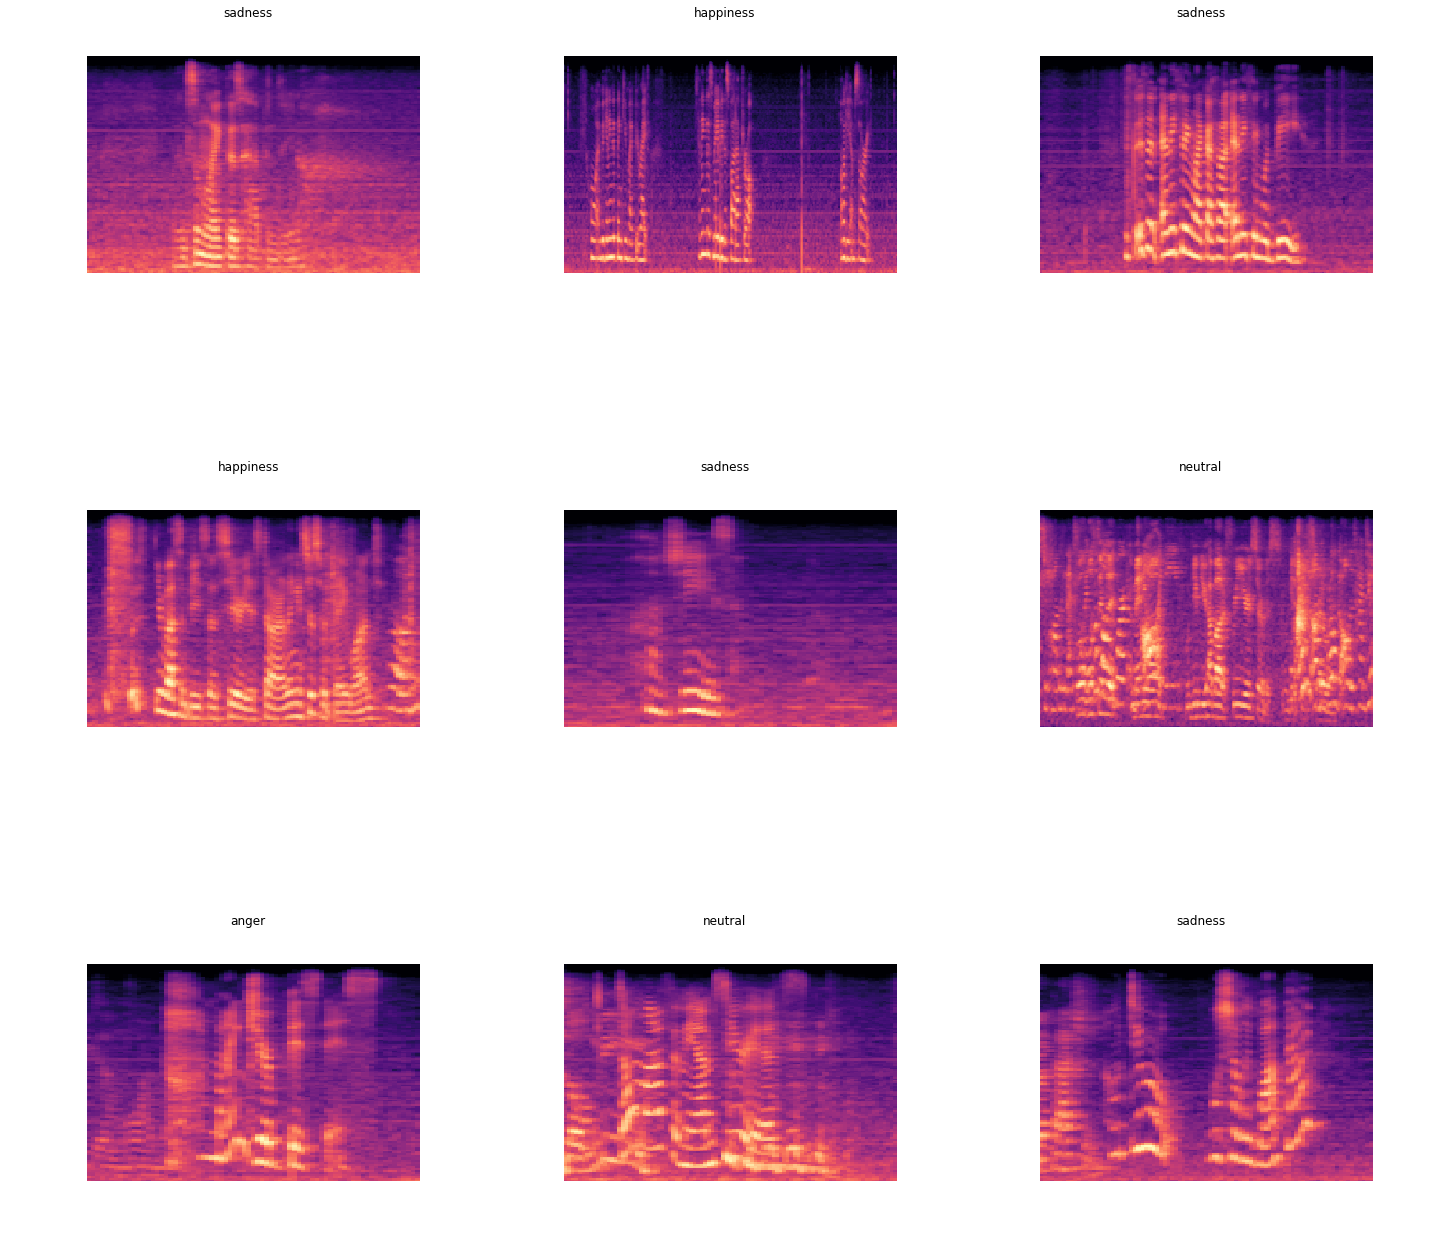

In [27]:
data.show_batch(rows=3,figsize=(20,20))

### Create model object corresponding to resnet34 architecture

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


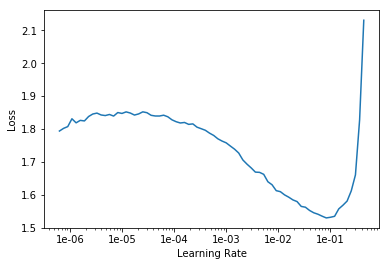

In [7]:
learn.lr_find()
learn.recorder.plot()


### Pick learning rate where curve is maximally decreasing

### Fit last layer of the model 

In [8]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

Total time: 10:28
epoch  train_loss  valid_loss  accuracy
1      1.241078    1.034500    0.605568  (02:14)
2      1.060820    0.968925    0.592807  (02:05)
3      0.936409    0.973663    0.631090  (02:03)
4      0.795626    0.885393    0.660093  (02:02)
5      0.650062    0.892627    0.655452  (02:03)



In [9]:
learn.save('stage-1-rn34')

In [11]:
learn.load('stage-1-rn34')

### Unfreeze first layers, assess loss wrt learning rate and train full model 

In [12]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


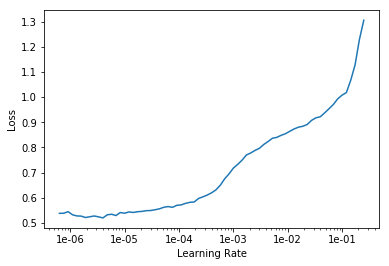

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(10, slice(5e-7, lr/5))

Total time: 28:00
epoch  train_loss  valid_loss  accuracy
1      0.548789    0.923870    0.658933  (02:47)
2      0.480139    1.044008    0.649652  (02:48)
3      0.381412    1.220775    0.612529  (02:48)
4      0.286155    1.400898    0.621810  (02:48)
5      0.177816    1.486815    0.635731  (02:48)
6      0.092419    1.593256    0.660093  (02:48)
7      0.052476    1.635659    0.664733  (02:47)
8      0.030814    1.654233    0.654292  (02:48)
9      0.019481    1.674734    0.650812  (02:48)
10     0.013692    1.634277    0.653132  (02:48)



### Analyze confusion matrix 

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

In [16]:
interp.most_confused(min_val=2)

[('sadness', 'neutral', 55),
 ('happiness', 'neutral', 48),
 ('neutral', 'sadness', 42),
 ('anger', 'neutral', 36),
 ('happiness', 'sadness', 28),
 ('neutral', 'happiness', 26),
 ('neutral', 'anger', 19),
 ('happiness', 'anger', 14),
 ('sadness', 'happiness', 11),
 ('anger', 'sadness', 8),
 ('anger', 'happiness', 7),
 ('sadness', 'anger', 5)]

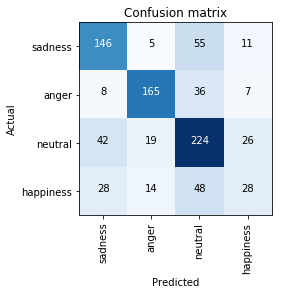

In [17]:
interp.plot_confusion_matrix()